# Exponential speedup with the Deutsch-Jozsa algorithm

## Introduction

The Deutsch-Jozsa algorithm[[1](#DJWiki)], named after David Deutsch and Richard Jozsa, is one of the fundamental and first quantum algorithms showing exponential speedup over their classical counterpart$^*$. While it has no practical applicative usage, it serves as a toy model for quantum computing, demonstrating how the concepts of super-position and interference enable quantum algorithms to overperform classical ones.

$^*$ The exponential speedup is in the oracle complexity setting. In addition, it only refers to determenistic classical machines (see comments below).

The algorithm treats the following problem:
* Consider a black-box boolean function $f(x)$ which acts on the integers in the range $[0, 2^{n}-1]$.
* It is guaranteed that the function is either constant or balanced ($\equiv$ for half of the values it is 1 and for the other half 0).
* The goal is to find in a deterministic way whether the function is constant or balanced.


## Create our own implementation

The circuit that we want to create is pictured below.
To create this circuit we need to implement 4 steps:

1. Apply the `hadamard_transform()` function on the qubits passed to the `main` function.
2. create an oracle with the `phase_oracle()` function, this is the function signature: (if you are stuck more details are below) 

        def phase_oracle(
            predicate: QCallable[QArray[QBit], QBit],
            target: QArray[QBit],
        )
        
3. Uncompute step 2 by applying the `hadamard_transform()` function to the 

Synthesize the circuit and execute in the IDE

<details>
<summary>
Detailed instructions on using <code>phase_oracle()</code>
</summary>
The function takes two named inputs:

1. predicate -> A `lambda` function with two inputs the target qubits and the auxiliary qubit, the expression will call the `my_black_box_prediate()`
2. target -> The target qubit register
</details>

<br />

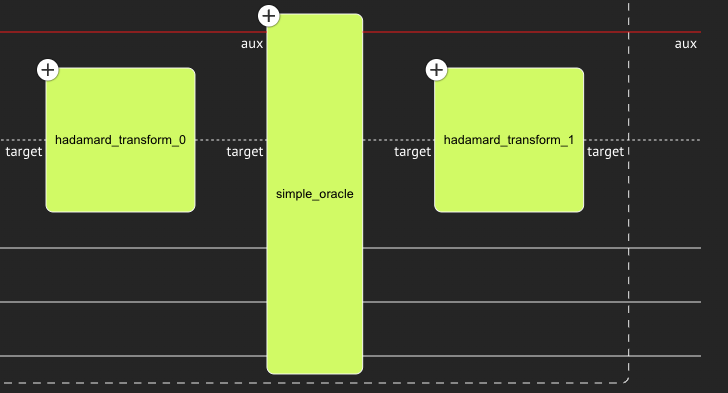


In [3]:
from classiq import *


@qfunc
def my_black_box_prediate(aux: QNum, target: QNum):
    aux ^= target > 4


@qfunc
def main(target: Output[QNum]):
    allocate(3, target)  # Allocate 3 qubits to the target register

    pass


qprog = synthesize(create_model(main))
show(qprog)

## Use within_apply

Writing the Hadamard transform twice might not be ideal. Therefore there is a shorthand, namely `within_apply`, this will allow you to define the function between the two Hadamard transforms and even use other funcitons beside hadamerd transfrom to wrap this. Let's create the same function as above but use the `within_apply` function. 

<details>
<summary>
Detailed instructions on using <code>within_apply</code>
</summary>
The function takes two named inputs:

1. compute -> A `lambda` function that holds the preparation and uncompute function. In this case the `hadamard_transform` function.
2. action -> A `lambda` function that holds the action that is wrapped within the compute functions. In this case that is the entire `simple_oracle`.
</details>

<br />

In [ ]:
@qfunc
def main(target: Output[QNum]):
    allocate(3, target)  # Allocate 3 qubits to the target register

    pass


qprog = synthesize(create_model(main))
show(qprog)

## Mathematical explanation

Below, we briefly go over the linear algebra behind the Deutsch-Jozsa algorithm. The first Hadamard transformation generates an equal superposition over all the standard basis elements:
$$
|0\rangle_n \xrightarrow[H^{\otimes n}]{} \frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}|j\rangle_n.
$$
Arithmetic oracle gets a boolean function and adds an $e^{\pi i}=-1$ phase to all states for which the function returns True:
$$
\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}|j\rangle_n \xrightarrow[\text{Oracle}(f(j))]{}\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}(-1)^{f(j)}|j\rangle_n.
$$
Finally, we apply the Hadamard transform, which can be written as $H^{\otimes n}\equiv \frac{1}{2^{n/2}}\sum^{2^n-1}_{k,l=0}(-1)^{k\cdot l} |k\rangle \langle l| $, to find
$$
\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}(-1)^{f(j)}|j\rangle  \xrightarrow[H^{\otimes n}]{} 
\sum^{2^n-1}_{k=0} \left(\frac{1}{2^{n}}\sum^{2^n-1}_{j=0}(-1)^{f(j)+j\cdot k}|j\rangle \right) |k\rangle.
$$

The probability of getting the state $|k\rangle = |0\rangle$ is
$$
P(0)=\left|\frac{1}{2^{n}}\sum^{2^n-1}_{j=0}(-1)^{f(j)}|j\rangle \right|^2 =
\left\{
\begin{array}{l l}
1 & \text{if } f(x) \text{ is constant} \\
0 & \text{if } f(x) \text{ is balanced}
\end{array}
\right.
$$

## Comments

If we do not require deterministic determination, namely, we can apply a classical probabilistic algorithm to get the result up to some error, then we lose the exponential speedup: taking $k$ classical evaluations of the function $f$ determines whether the function is constant or balanced, with a probability $1-1/2^k$.

### The full solution for your reference

In [2]:
@qfunc
def my_black_box_prediate(aux: QNum, target: QNum):
    aux ^= target > 4


@qfunc
def main(target: Output[QNum]):
    allocate(3, target)  # Allocate 3 qubits to the target register

    within_apply(
        within=lambda: hadamard_transform(target=target),
        apply=lambda: phase_oracle(
            predicate=lambda target, aux: my_black_box_prediate(aux=aux, target=target),
            target=target,
        ),
    )


qprog = synthesize(create_model(main))
show(qprog)